# Predicting Gender of Shughni Nouns Using Machine Learning Methods

## Modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json, os, re
from tqdm.notebook import tqdm

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from scipy.sparse import hstack, csr_matrix
from scipy.stats import mode, chisquare

import gensim.downloader as api
from gensim.models import KeyedVectors
from gensim.utils import simple_preprocess

import warnings
warnings.filterwarnings("ignore")

sns.set_context("paper", font_scale=1.2, rc={"axes.titlesize": 12})
DPI = 300

In [2]:
y_pred = {}         # dictionary with predicted gender values from different features and models
y_test = {}         # dictionary with correct gender values
results = {}        # results from different features, models and random seeds
mean_results = {}   # results from different features and models, mean for all random seeds
models = {}         # models used in predictions from different features (necessary to show feature importances)

In [3]:
RANDOM_SEEDS = [42, 27, 83, 3, 18, 59, 76, 15, 94, 55]
N_RS = len(RANDOM_SEEDS)

## Data preparation

### Loading the data

In [4]:
data = pd.read_csv("data.csv")
data = data[
    (data["meaning_gender"].isin(["m", "f"])) &
    (~data["comment"].isin(["adjective", "fluid", "onomatopoeia", "name", "abstr human"])) &
    (data["russian_borrowing"] != 1)
]
data["meaning_gender"] = pd.Categorical(data["meaning_gender"], categories=["f", "m"])

### Extracting the features

In [5]:
sem_features = ["human", "sex=f", "sex=m",
                "ind_spec", "mass_abstr", "large", "small",
                "animal", "water", "tree", "fruit", "tech_transport", "cultural_product",
                "household_object", "food", "drink", "plant", "event", "pos", "neg",
                "weather", "body_part", "building", "landscape", "diary_product", "sickness"]
morph_features = ["suffix_ak", "suffix_bVc", "deverbal", "infinitive"]
vowels = ("a", "ā", "e", "ê", "i", "ī", "o", "u", "ū", "ů")

bad_letters = [("x̌", "X"), ("ɣ̌", "G"), ("ǰ", "j")]

In [6]:
def extract_n_letters(word, n):
    for pair in bad_letters:
        word = re.sub(pair[0], pair[1], word)
    
    if len(word)<n:
        return ""
    
    suffix = ""
    for i in range(len(word)-1, len(word)-n-1, -1):
        if word[i] == "-":
            return ""
        suffix = word[i] + suffix

    for pair in bad_letters:
        suffix = re.sub(pair[1], pair[0], suffix)
    return suffix


#def extract_n_letters_from_all_forms(forms, n):
#    forms = forms.split()
#    results = [extract_n_letters(form, n) for form in forms]  
#    return " ".join(results)
#grouped = True


def last_vowel(word):
    for i in range(len(word)-1, -1, -1):
        if word[i] in vowels:
            return word[i]


def final_cons(word):
    for pair in bad_letters:
        word = re.sub(pair[0], pair[1], word)
    if not word[-1] in vowels:
        cons = word[-1]
        for pair in bad_letters:
            cons = re.sub(pair[1], pair[0], cons)
        return cons
    return "—"

In [7]:
last_N = range(1, 5)

if "grouped" in globals():
    if grouped == True:
        for n in last_N:
            data[f"last_{n}"] = data["all_forms"].apply(lambda x: extract_n_letters_from_all_forms(x, n))
    else:
        for n in last_N:
            data[f"last_{n}"] = data["form"].apply(lambda x: extract_n_letters(x, n))
else:
    for n in last_N:
        data[f"last_{n}"] = data["form"].apply(lambda x: extract_n_letters(x, n))

last_N_features = [f"last_{n}" for n in last_N]

data["last_vowel"] = data["form"].apply(lambda x: last_vowel(x))
#data["final_cons"] = data["form"].apply(lambda x: final_cons(x))

phon_features = ["last_vowel"]

In [8]:
#data.head(5)
#data.to_csv("res_subset_forms.csv")

### Exploring the features

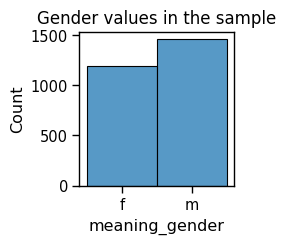

In [9]:
plt.figure(figsize=(2, 2))
sns.histplot(data["meaning_gender"])
plt.title("Gender values in the sample")
plt.savefig("gender values.png", bbox_inches="tight", dpi=DPI)
plt.show()

In [10]:
ratio_F = data["meaning_gender"].value_counts()["f"] / data["meaning_gender"].count()
print(f"label F: {data['meaning_gender'].value_counts()['f']} ({round(ratio_F*100)}%)")
print(f"label M: {data['meaning_gender'].value_counts()['m']} ({round((1-ratio_F)*100)}%)")

label F: 1195 (45%)
label M: 1459 (55%)


#### Last vowel / consonant

In [11]:
def plot_last_distribution(feature, title, FIGSIZE):
    if FIGSIZE:
        plt.figure(figsize=FIGSIZE)
    sns.histplot(pd.Categorical(data[feature], vowels))
    plt.title(f"‘{title}’ values")
    plt.savefig(f"{feature} values.png", bbox_inches="tight", dpi=DPI)
    plt.show()


def plot_last_across_gender(feature, title, chi_p=0.05, FIGSIZE=None):
    last_gender = data.groupby(by=[feature, "meaning_gender"])["meaning_gender"].size().unstack(fill_value=0)
    last_gender["f_perc"] = round(last_gender["f"] / (last_gender["f"] + last_gender["m"]), 2)
    last_gender["m_perc"] = round(last_gender["m"] / (last_gender["f"] + last_gender["m"]), 2)
    last_gender = last_gender.sort_values("f_perc", ascending=False)
    
    last_gender["sum"] = last_gender["f"] + last_gender["m"]
    last_gender["f_exp"] = round(last_gender["sum"] * ratio_F)
    last_gender["m_exp"] = round(last_gender["sum"] - last_gender["f_exp"])
    
    last_gender["pvalue"] = [round(chisquare(
        f_obs=(vowel[1]["f"], vowel[1]["m"]),
        f_exp=(vowel[1]["f_exp"], vowel[1]["m_exp"])).pvalue, 4) for vowel in last_gender.iterrows()]
    last_gender = last_gender[last_gender["pvalue"]<=chi_p]

    if FIGSIZE:
        plt.figure(figsize=FIGSIZE)
    sns.heatmap(last_gender[["f_perc", "m_perc"]].T, annot=last_gender[["f", "m"]].T, fmt="g", vmin=0, vmax=1)
    plt.title(f"Most gendered ‘{title}’ values")
    plt.savefig(f"{feature} values by gender.png", bbox_inches='tight', dpi=DPI)
    plt.show()

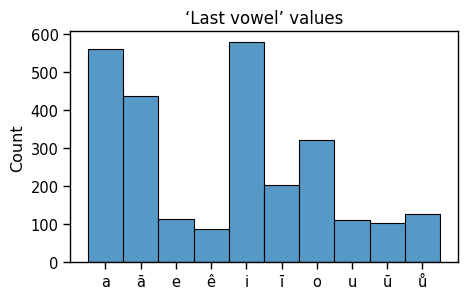

In [12]:
plot_last_distribution("last_vowel", "Last vowel", (5, 3))

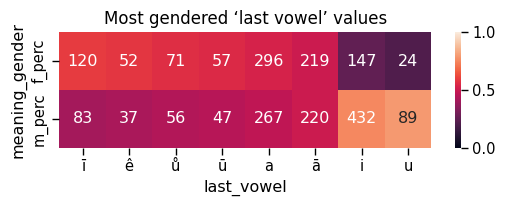

In [13]:
plot_last_across_gender("last_vowel", "last vowel", 0.05, (6, 1.5))

#### Last N

In [14]:
def get_popular_endings(feature, endings_max=30, n_min=20):
    popular_endings = data[feature].value_counts()[:endings_max]
    return popular_endings[popular_endings>n_min]


def plot_endings(endings, feature, title, FIGSIZE=None):
    if FIGSIZE:
        plt.figure(figsize=FIGSIZE)
    sns.barplot(endings)
    plt.title(f"‘{title}’ values")
    plt.savefig(f"{feature} values.png", bbox_inches='tight', dpi=DPI)
    plt.show()


def plot_endings_across_gender(popular_endings, feature, title, THRESHOLD=0.4, FIGSIZE=None):
    last_gender = data[data[feature].isin(popular_endings.keys())].groupby(by=[feature, "meaning_gender"])["meaning_gender"].size().unstack(fill_value=0)
    last_gender["f_perc"] = round(last_gender["f"] / (last_gender["f"] + last_gender["m"]), 2)
    last_gender["m_perc"] = round(last_gender["m"] / (last_gender["f"] + last_gender["m"]), 2)
    last_gender = last_gender[(last_gender["m_perc"]<THRESHOLD) | (last_gender["f_perc"]<THRESHOLD)].sort_values("f_perc", ascending=False)
    
    if FIGSIZE:
        plt.figure(figsize=FIGSIZE)
    sns.heatmap(last_gender[["f_perc", "m_perc"]].T, annot=last_gender[["f", "m"]].T, fmt="g", vmin=0, vmax=1)
    plt.title(f"Most gendered ‘{title}’ values")
    plt.savefig(f"{feature} by gender.png", bbox_inches='tight', dpi=DPI)
    plt.show()

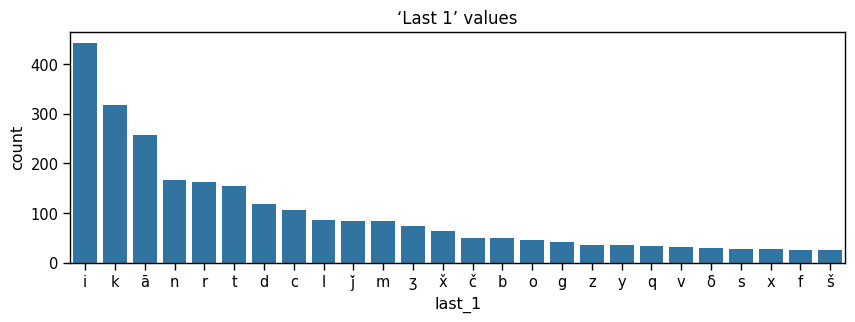

In [15]:
plot_endings(get_popular_endings("last_1"), "last_1", "Last 1", (10, 3))

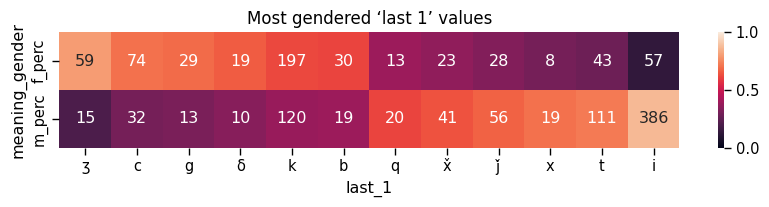

In [16]:
plot_endings_across_gender(get_popular_endings("last_1"), "last_1", "last 1", FIGSIZE=(10, 1.5))

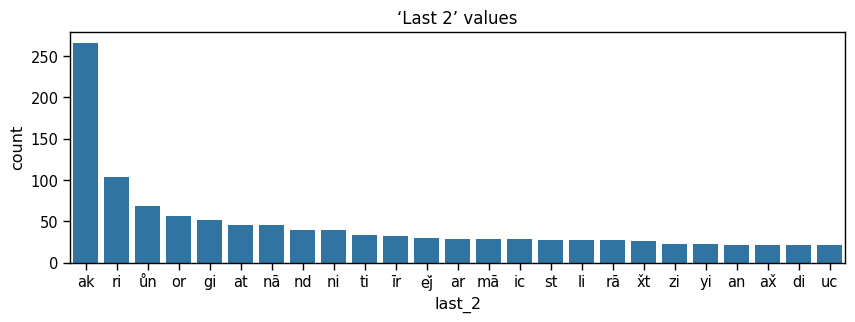

In [17]:
plot_endings(get_popular_endings("last_2"), "last_2", "Last 2", (10, 3))

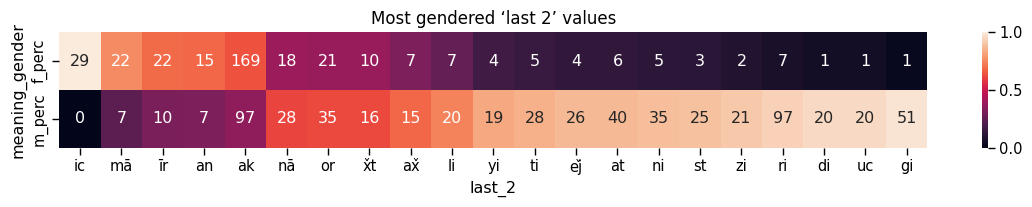

In [18]:
plot_endings_across_gender(get_popular_endings("last_2"), "last_2", "last 2", FIGSIZE=(14, 1.5))

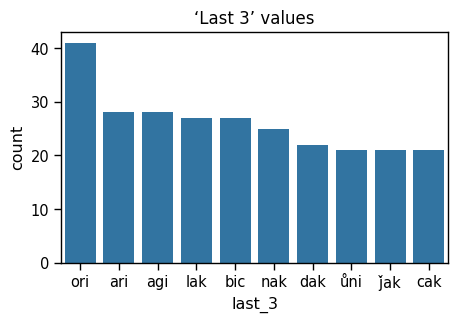

In [19]:
plot_endings(get_popular_endings("last_3"), "last_3", "Last 3", (5, 3))

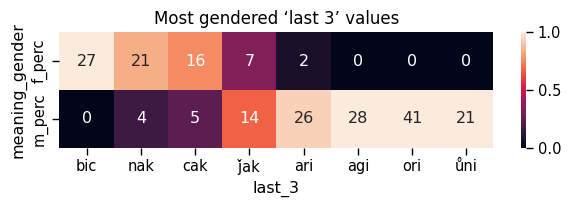

In [20]:
plot_endings_across_gender(get_popular_endings("last_3"), "last_3", "last 3", FIGSIZE=(7, 1.5))

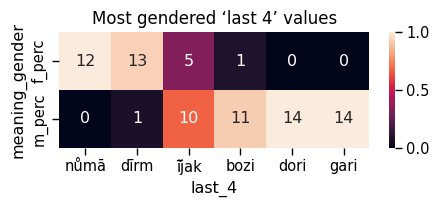

In [21]:
plot_endings_across_gender(get_popular_endings("last_4", endings_max=50, n_min=10), "last_4", "last 4", FIGSIZE=(5, 1.5))

#### Semantic features

In [22]:
def plot_semantic_feature(feature, FIGSIZE=(2, 2)):
    sem_gender = data.groupby(by=[feature, "meaning_gender"])["meaning_gender"].size().unstack(fill_value=0)
    sem_gender["f_perc"] = round(sem_gender["f"] / (sem_gender["f"] + sem_gender["m"]), 2)
    sem_gender["m_perc"] = round(sem_gender["m"] / (sem_gender["f"] + sem_gender["m"]), 2)
    sem_gender = sem_gender.sort_values(feature, ascending=True)
    
    plt.figure(figsize=FIGSIZE)
    sns.heatmap(sem_gender[["f_perc", "m_perc"]].T, annot=sem_gender[["f", "m"]].T, fmt="g", vmin=0, vmax=1)
    plt.title(f"Gender across ‘{feature}’ feature")
    plt.savefig(f"{feature} heatmap.png", bbox_inches='tight', dpi=DPI)
    plt.show()

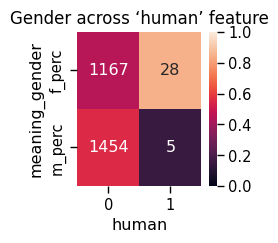

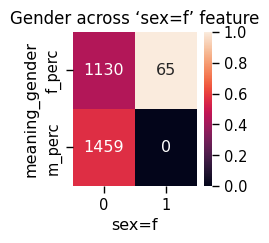

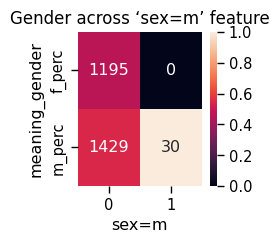

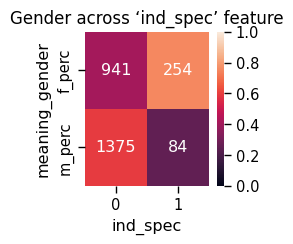

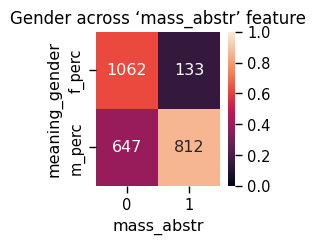

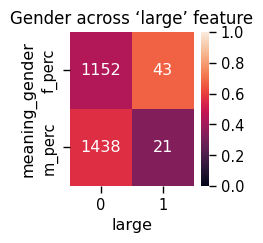

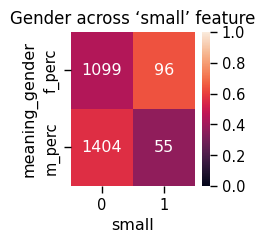

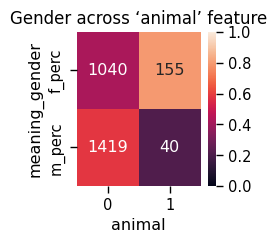

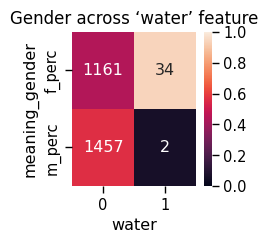

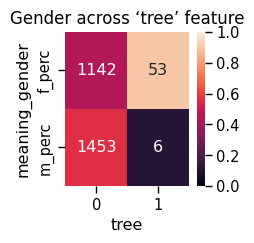

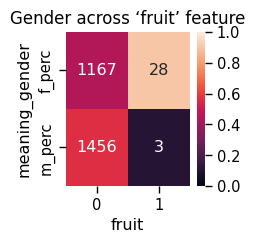

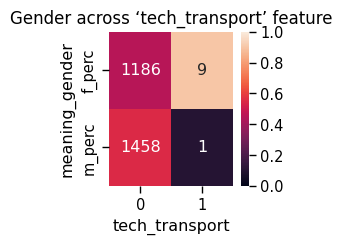

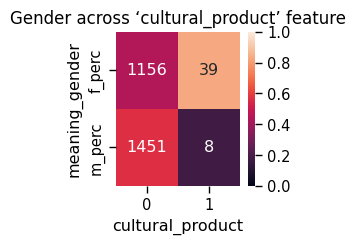

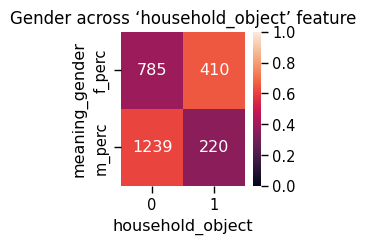

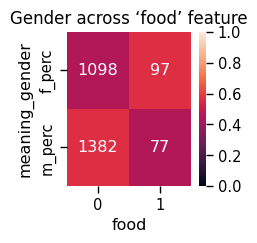

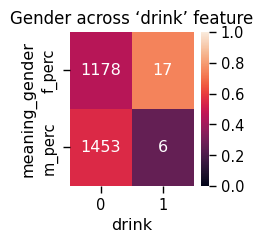

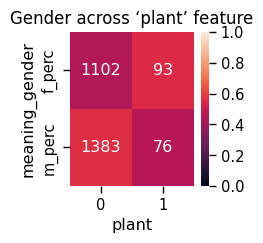

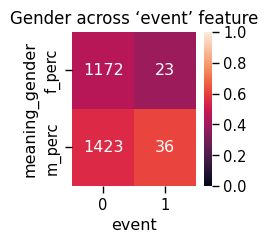

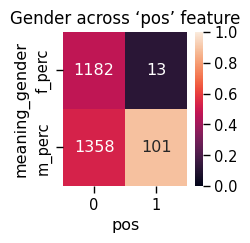

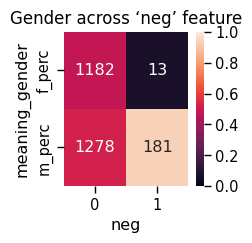

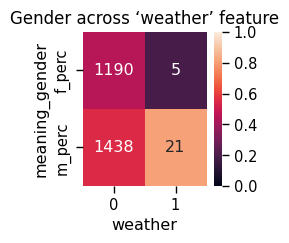

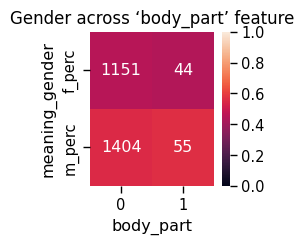

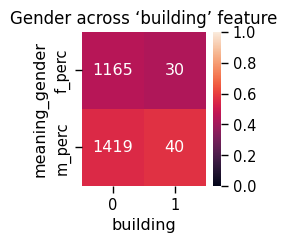

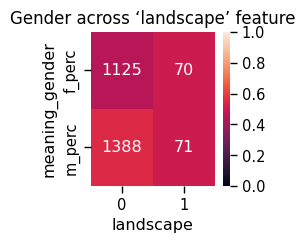

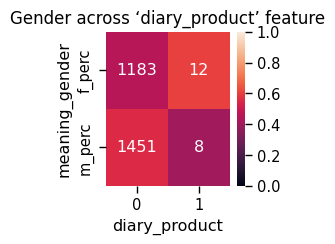

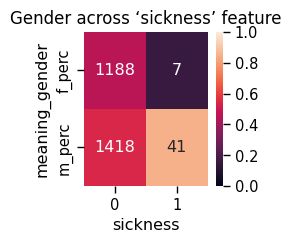

In [23]:
for sem_feature in sem_features:
    plot_semantic_feature(sem_feature)

#### Morphological features

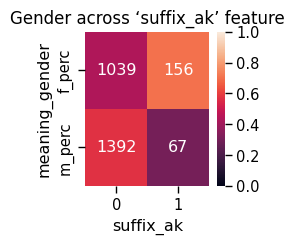

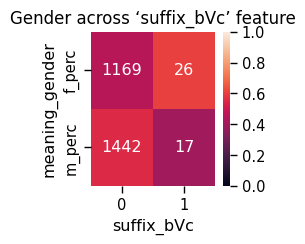

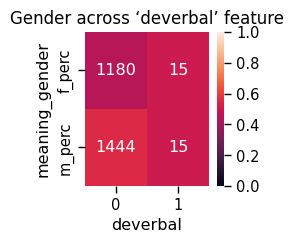

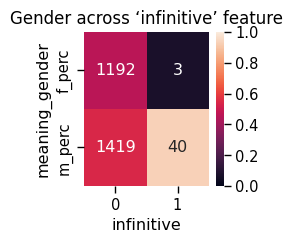

In [24]:
for morph_feature in morph_features:
    plot_semantic_feature(morph_feature)

## Training preparation

### Training and transformation functions

In [12]:
def fit_predict(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    _y_pred = model.predict(X_test)
    return _y_pred, classification_report(y_test, _y_pred, output_dict=True)


def train_models(X_train, y_train, X_test, y_test, model, settings, tuned_params=False):

    if model=="MNB":
        _model = MultinomialNB(
            alpha=settings["MNB_ALPHA"],
            fit_prior=True,
        )
        _y_pred, _results = fit_predict(
            _model, X_train, y_train, X_test, y_test)
        _y_train_pred = _model.predict(X_train)
        _results["accuracy_train"] = accuracy_score(y_train, _y_train_pred)
    
    elif model=="LOG":
        _model = LogisticRegression(
            penalty=settings["LOG_PENALTY"],
            C=settings["LOG_C"],
            solver=settings["LOG_SOLVER"]
        )
        _y_pred, _results = fit_predict(
            _model, X_train, y_train, X_test, y_test)
        _y_train_pred = _model.predict(X_train)
        _results["accuracy_train"] = accuracy_score(y_train, _y_train_pred)
    
    elif model=="SGD":
        _model = SGDClassifier(
            penalty=settings["SGD_PENALTY"],
            alpha=settings["SGD_ALPHA"],
            learning_rate=settings["SGD_LR"]
        )
        _y_pred, _results = fit_predict(
            _model, X_train, y_train, X_test, y_test)
        _y_train_pred = _model.predict(X_train)
        _results["accuracy_train"] = accuracy_score(y_train, _y_train_pred)
    
    elif model=="RFC":
        _model = RandomForestClassifier(
            max_depth=settings["RFC_MAX_DEPTH"],
            min_samples_leaf=settings["RFC_MIN_SAMPLES_LEAF"]
        )
        _y_pred, _results = fit_predict(
            _model, X_train, y_train, X_test, y_test)
        _results["accuracy_train"] = _model.score(X_train, y_train)
    
    elif model=="DTC":
        _model = DecisionTreeClassifier(
            max_depth=settings["DTC_MAX_DEPTH"],
            min_samples_leaf=settings["DTC_MIN_SAMPLES_LEAF"],
            min_weight_fraction_leaf=0.001,
            min_impurity_decrease=settings["DTC_MIN_IMPURITY_DECREASE"]
        )
        _y_pred, _results = fit_predict(
            _model, X_train, y_train, X_test, y_test)
        _results["accuracy_train"] = _model.score(X_train, y_train)

    elif model=="CATB":
        _model = CatBoostClassifier(
            iterations=settings["CATB_ITERATIONS"],
            learning_rate=settings["CATB_LR"],
            depth=settings["CATB_DEPTH"],
            silent=True
        )
        _y_pred, _results = fit_predict(
            _model, X_train, y_train, X_test, y_test)
        _results["accuracy_train"] = _model.score(X_train, y_train)

    return _y_pred, _results, _model


def show_accuracy(results):
    return {key: round(results[key]["accuracy"], 4) for key in results.keys()}


def show_class_score(results, score_name):
    class_score = {}
    for key in results.keys():
        class_score[key] = {}
        for class_ in ("f", "m"):
            class_score[key][class_] = round(results[key][class_][score_name], 4) 
    return class_score


def show_overfitting(results, model):
    accs = {}
    accs["accuracy_test"] = round(results[model]["accuracy"], 4)
    if "accuracy_train" in results[model]:
        accs["accuracy_train"] = round(results[model]["accuracy_train"], 4)
    return accs


def show_importances(model, features, n=20):
    indices = np.argsort(model.feature_importances_)[::-1]
    importances = []
    for f in range(min(n, len(features))):
        importances.append({
            "feature": features[indices[f]],
            "importance": model.feature_importances_[indices[f]]
        })
    return pd.DataFrame(importances, index=range(1, min(n, len(features))+1))


def transform_VECTORIZER(feature):
    return CountVectorizer().fit_transform(data[feature])


def transform_average_vectors(feature):
    vectors = CountVectorizer().fit_transform(data[feature]).toarray()
    return np.array([
        vectors[i] / np.sum(vectors[i]) if np.sum(vectors[i]) > 0 else np.zeros(vectors.shape[1])
        for i in range(vectors.shape[0])
    ])


def transform_OHE(feature):
    ohe = OneHotEncoder()
    return ohe.fit_transform(data[[feature]]), ohe.get_feature_names_out()


def load_fasttext_model():
    model_path = "fasttext_wiki_news_subwords_300.kv"
    if os.path.exists(model_path):
        model = KeyedVectors.load(model_path)  
    else:
        model = api.load("fasttext-wiki-news-subwords-300")
        model.save(model_path)
    return model


def transform_FASTTEXT(feature):
    model = load_fasttext_model()
    
    def vectorize_text(text):
        words = simple_preprocess(text, deacc=True)
        word_vectors = [model[word] for word in words if word in model]
        if not word_vectors:
            return np.zeros(model.vector_size)
        return np.mean(word_vectors, axis=0)
    return np.array([vectorize_text(text) for text in data[feature]])


def transform_x_vectors(vector_features):
    for _FEATURE in vector_features:
        x_feature_values[_FEATURE] = transform_VECTORIZER(_FEATURE)
    #for _FEATURE in ("meaning_with_examples_pretrained",):
    #    x_feature_values["meaning_with_examples_pretrained"] = transform_FASTTEXT(_FEATURE)


def transform_x_phon_features(_phon_features):
    for _FEATURE in _phon_features:
        x_feature_values[_FEATURE], _vowels_feature_names = transform_OHE(_FEATURE)
    return _vowels_feature_names


def transform_x_last(_last_N_features):
    _word_endings = {}
    if "grouped" in globals():
        if grouped == True:
            for _FEATURE in _last_N_features:
                x_feature_values[_FEATURE] = transform_average_vectors(_FEATURE)
        for _FEATURE in _last_N_features:
            x_feature_values[_FEATURE], _word_endings[_FEATURE] = transform_OHE(_FEATURE)
    else:
        for _FEATURE in _last_N_features:
            x_feature_values[_FEATURE], _word_endings[_FEATURE] = transform_OHE(_FEATURE)
    return _word_endings

### Transforming _x_-values

In [10]:
x_feature_values = {}

vowels_feature_names = list(transform_x_phon_features(["last_vowel"]))
x_feature_values["last_vowel"] = pd.DataFrame.sparse.from_spmatrix(x_feature_values["last_vowel"], columns=vowels_feature_names)

x_feature_values["morph_features"] = data[morph_features]

word_endings = transform_x_last(last_N_features)
word_endings = list(x for e in word_endings.values() for x in list(e))
x_feature_values["last_ngrams"] = hstack([x_feature_values[last_N] for last_N in last_N_features])
x_feature_values["last_ngrams"] = pd.DataFrame.sparse.from_spmatrix(x_feature_values["last_ngrams"], columns=word_endings)

for last_N in last_N_features:
    del x_feature_values[last_N]

x_feature_values["last_ngrams + last_vowel"] = np.column_stack([x_feature_values["last_ngrams"], x_feature_values["last_vowel"]])

transform_x_vectors(("meaning", "meaning_with_examples",))
x_feature_values["sem_features"] = data[sem_features]

x_feature_values["sem + last_ngrams"] = np.column_stack([x_feature_values["sem_features"], x_feature_values["last_ngrams"]])
x_feature_values["sem + morph"] = np.column_stack([x_feature_values["sem_features"], x_feature_values["morph_features"]])

x_feature_values["all_nonvectorized"] = np.column_stack([x_feature_values["sem_features"], x_feature_values["last_vowel"], x_feature_values["last_ngrams"], x_feature_values["morph_features"]])
all_nonvectorized_feature_names = sem_features + vowels_feature_names + word_endings + morph_features
x_feature_values["all_nonvectorized"] = pd.DataFrame(x_feature_values["all_nonvectorized"], columns=all_nonvectorized_feature_names).astype(int)

x_feature_values["sem + meaning_we"] = hstack([x_feature_values["sem_features"], x_feature_values["meaning_with_examples"]])
x_feature_values["sem + meaning_we + last_ngrams"] = hstack([x_feature_values["sem_features"], x_feature_values["meaning_with_examples"], x_feature_values["last_ngrams"]])
x_feature_values["sem + meaning_we + morph"] = hstack([x_feature_values["sem_features"], x_feature_values["meaning_with_examples"], x_feature_values["morph_features"]])

x_feature_values["all"] = hstack([x_feature_values["sem_features"], x_feature_values["meaning_with_examples"], x_feature_values["last_ngrams"], x_feature_values["morph_features"]])

In [11]:
def delete_small_variance(feature, THRESHOLD=0.0005):
    init_len = x_feature_values[feature].shape[1]
    selector = VarianceThreshold(threshold=THRESHOLD)
    x_feature_values[feature] = selector.fit_transform(x_feature_values[feature])
    indices = selector.get_support(indices=True)
    end_len = x_feature_values[feature].shape[1]
    print(f"‘{feature}’: {round((init_len-end_len)/init_len*100, 2)}% deleted ({init_len} —> {end_len})")
    return indices

In [13]:
NONVECTORIZED_FEATURE_NAMES = {
    "last_vowel": vowels_feature_names,
    "morph_features": morph_features,
    "last_ngrams": word_endings,
    "sem_features": sem_features,
    "all_nonvectorized": all_nonvectorized_feature_names,
}

In [14]:
SELECT_FEATURES = True

if SELECT_FEATURES:
    for feature in tqdm(x_feature_values, desc="FEATURES"):
        var_threshold = 0.0005
        remaining_indices = list(delete_small_variance(feature, var_threshold))
        if feature in NONVECTORIZED_FEATURE_NAMES:
            selected_feature_names = [NONVECTORIZED_FEATURE_NAMES[feature][i] for i in remaining_indices]
            if not isinstance(x_feature_values[feature], np.ndarray):
                x_feature_values[feature] = x_feature_values[feature].toarray()
            x_feature_values[feature] = pd.DataFrame(x_feature_values[feature], columns=selected_feature_names)
        #delete_collinear(feature, 0.95)
selected = "" if SELECT_FEATURES else "_fullfeat"

FEATURES:   0%|          | 0/14 [00:00<?, ?it/s]

‘last_vowel’: 0.0% deleted (10 —> 10)
‘morph_features’: 0.0% deleted (4 —> 4)
‘last_ngrams’: 64.06% deleted (3164 —> 1137)
‘last_ngrams + last_vowel’: 63.86% deleted (3174 —> 1147)
‘meaning’: 69.14% deleted (4816 —> 1486)
‘meaning_with_examples’: 62.59% deleted (9589 —> 3587)
‘sem_features’: 0.0% deleted (26 —> 26)
‘sem + last_ngrams’: 63.54% deleted (3190 —> 1163)
‘sem + morph’: 0.0% deleted (30 —> 30)
‘all_nonvectorized’: 63.26% deleted (3204 —> 1177)
‘sem + meaning_we’: 62.42% deleted (9615 —> 3613)
‘sem + meaning_we + last_ngrams’: 62.83% deleted (12779 —> 4750)
‘sem + meaning_we + morph’: 62.4% deleted (9619 —> 3617)
‘all’: 62.81% deleted (12783 —> 4754)


## Training

### Settings

In [15]:
SETTINGS = {                                 # ↓ default
    "MNB_ALPHA": 0.5,                        #   1.0
    "LOG_PENALTY": "l1",
    "LOG_C": 1.5,
    "LOG_SOLVER": "liblinear",
    "SGD_PENALTY": "l1",
    "SGD_ALPHA": 0.5,
    "SGD_LR": "optimal",
    "RFC_MAX_DEPTH": 30,                     #   None
    "RFC_MIN_SAMPLES_LEAF": 7,               #   1
    "DTC_MAX_DEPTH": 30,                     #   None
    "DTC_MIN_SAMPLES_LEAF": 7,               #   1
    "DTC_MIN_IMPURITY_DECREASE": 0.001,
    "CATB_ITERATIONS": 500,
    "CATB_LR": 0.01,
    "CATB_DEPTH": 8
}

In [16]:
def TRAIN(FEATURES):
    X_train, X_test, y_train, y_test = {}, {}, {}, {}
    
    for FEATURE in tqdm(FEATURES, desc="FEATURES"):
        X_train[FEATURE], X_test[FEATURE], y_pred[FEATURE], results[FEATURE],  models[FEATURE] = {}, {}, {}, {}, {}
        for MODEL in tqdm(MODELS_TO_TRAIN, desc="MODELS", leave=False):
            y_pred[FEATURE][MODEL], results[FEATURE][MODEL], models[FEATURE][MODEL] = {}, {}, {}
            for rseed in RANDOM_SEEDS:
                X_train[FEATURE][rseed], X_test[FEATURE][rseed], y_train[rseed], y_test[rseed] = train_test_split(
                    x_feature_values[FEATURE], data["meaning_gender"], test_size=0.2,
                    random_state=rseed)
                y_pred[FEATURE][MODEL][rseed], results[FEATURE][MODEL][rseed], models[FEATURE][MODEL][rseed] = train_models(
                    X_train[FEATURE][rseed], y_train[rseed],
                    X_test[FEATURE][rseed], y_test[rseed],
                    MODEL, SETTINGS)

    for FEATURE in tqdm(FEATURES, desc="ANALYSIS"):
        mean_results[FEATURE] = {}
        for MODEL in MODELS_TO_TRAIN:
            mean_results[FEATURE][MODEL] = {}
            for rseed in RANDOM_SEEDS:
                
                mean_results[FEATURE][MODEL][rseed] = {
                    "f_precision": results[FEATURE][MODEL][rseed]["f"]["precision"],
                    "f_recall": results[FEATURE][MODEL][rseed]["f"]["recall"],
                    "f_f1-score": results[FEATURE][MODEL][rseed]["f"]["f1-score"],
                    "m_precision": results[FEATURE][MODEL][rseed]["m"]["precision"],
                    "m_recall": results[FEATURE][MODEL][rseed]["m"]["recall"],
                    "m_f1-score": results[FEATURE][MODEL][rseed]["m"]["f1-score"],
                    "accuracy": results[FEATURE][MODEL][rseed]["accuracy"],
                    "precision-weighted": results[FEATURE][MODEL][rseed]["weighted avg"]["precision"],
                    "recall-weighted": results[FEATURE][MODEL][rseed]["weighted avg"]["recall"],
                    "f1-score-weighted": results[FEATURE][MODEL][rseed]["weighted avg"]["f1-score"]
                }
                
                for CLASS in ("m", "f"):
                    ys = pd.DataFrame({"y_test": y_test[rseed], "y_pred": y_pred[FEATURE][MODEL][rseed]})
                    ys = ys[ys["y_test"] == CLASS]
                    matrix = confusion_matrix(ys["y_test"], ys["y_pred"])
                    number = 0 if CLASS == "f" else 1
                    if len(matrix) == 1 and len(matrix[0]) == 1:
                        mean_results[FEATURE][MODEL][rseed][f"{CLASS}_accuracy"] = 1
                    else:
                        mean_results[FEATURE][MODEL][rseed][f"{CLASS}_accuracy"] = (matrix.diagonal()/matrix.sum(axis=1))[number]

    for FEATURE in FEATURES:
        results[FEATURE] = {}
        for MODEL in MODELS_TO_TRAIN:
            res_table = pd.DataFrame(mean_results[FEATURE][MODEL])
            results[FEATURE][MODEL], mean_results[FEATURE][MODEL] = {}, {}
            for row in res_table.index:
                results[FEATURE][MODEL][row] = tuple(res_table.loc[row])
                mean_results[FEATURE][MODEL][row] = {}
                mean_results[FEATURE][MODEL][row]["mean"] = round(np.mean(results[FEATURE][MODEL][row]), 3)
                mean_results[FEATURE][MODEL][row]["std"] = round(np.std(results[FEATURE][MODEL][row]), 3)
    return y_test

### Training on features

In [17]:
MODELS_TO_TRAIN = (
    "MNB",
    #"LOG",
    #"SGD",
    "DTC",
    "RFC",
    #"CATB"
)

In [18]:
print("FEATURES:", tuple(x_feature_values.keys()))
print("MODELS:", MODELS_TO_TRAIN)
y_test = TRAIN(x_feature_values.keys())

FEATURES: ('last_vowel', 'morph_features', 'last_ngrams', 'last_ngrams + last_vowel', 'meaning', 'meaning_with_examples', 'sem_features', 'sem + last_ngrams', 'sem + morph', 'all_nonvectorized', 'sem + meaning_we', 'sem + meaning_we + last_ngrams', 'sem + meaning_we + morph', 'all')
MODELS: ('MNB', 'DTC', 'RFC')


FEATURES:   0%|          | 0/14 [00:00<?, ?it/s]

MODELS:   0%|          | 0/3 [00:00<?, ?it/s]

MODELS:   0%|          | 0/3 [00:00<?, ?it/s]

MODELS:   0%|          | 0/3 [00:00<?, ?it/s]

MODELS:   0%|          | 0/3 [00:00<?, ?it/s]

MODELS:   0%|          | 0/3 [00:00<?, ?it/s]

MODELS:   0%|          | 0/3 [00:00<?, ?it/s]

MODELS:   0%|          | 0/3 [00:00<?, ?it/s]

MODELS:   0%|          | 0/3 [00:00<?, ?it/s]

MODELS:   0%|          | 0/3 [00:00<?, ?it/s]

MODELS:   0%|          | 0/3 [00:00<?, ?it/s]

MODELS:   0%|          | 0/3 [00:00<?, ?it/s]

MODELS:   0%|          | 0/3 [00:00<?, ?it/s]

MODELS:   0%|          | 0/3 [00:00<?, ?it/s]

MODELS:   0%|          | 0/3 [00:00<?, ?it/s]

ANALYSIS:   0%|          | 0/14 [00:00<?, ?it/s]

In [25]:
with open("mean_results.json", "w", encoding="utf-8-sig") as f:
    json.dump(mean_results, f, indent=2, ensure_ascii=False)

## Analysis

In [26]:
with open("mean_results.json", "r", encoding="utf-8-sig") as f:
    mean_results = json.load(f)

### F1-score

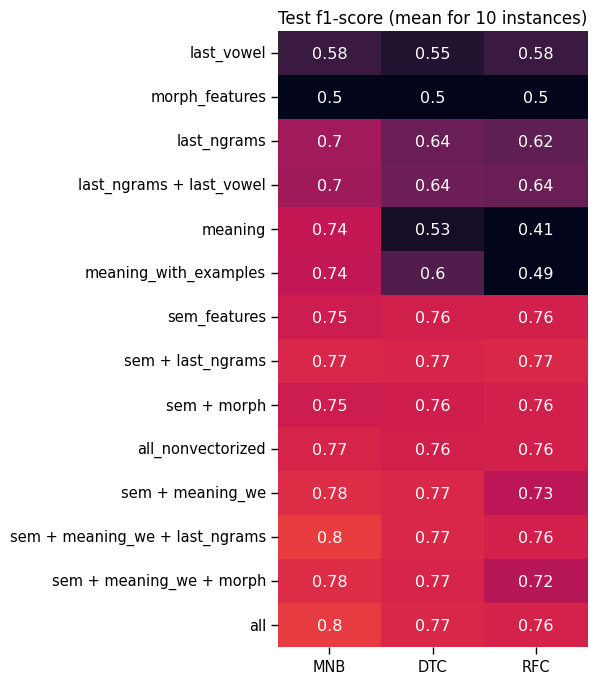

In [27]:
accuracies = {}
for feature_ in mean_results:
    accuracies[feature_] = [mean_results[feature_][model_]["f1-score-weighted"]["mean"] for model_ in mean_results[feature_]]
accuracies = pd.DataFrame(accuracies, index=mean_results[feature_]).transpose()

plt.figure(figsize=(4, 8))
sns.heatmap(accuracies, vmin=0.5, vmax=1, annot=True, cbar=False)
plt.title(f"Test f1-score (mean for {N_RS} instances)")
#plt.xticks(rotation=20, ha="right")
plt.savefig(f"f1_test{selected}.png", bbox_inches='tight', dpi=DPI)
plt.show()

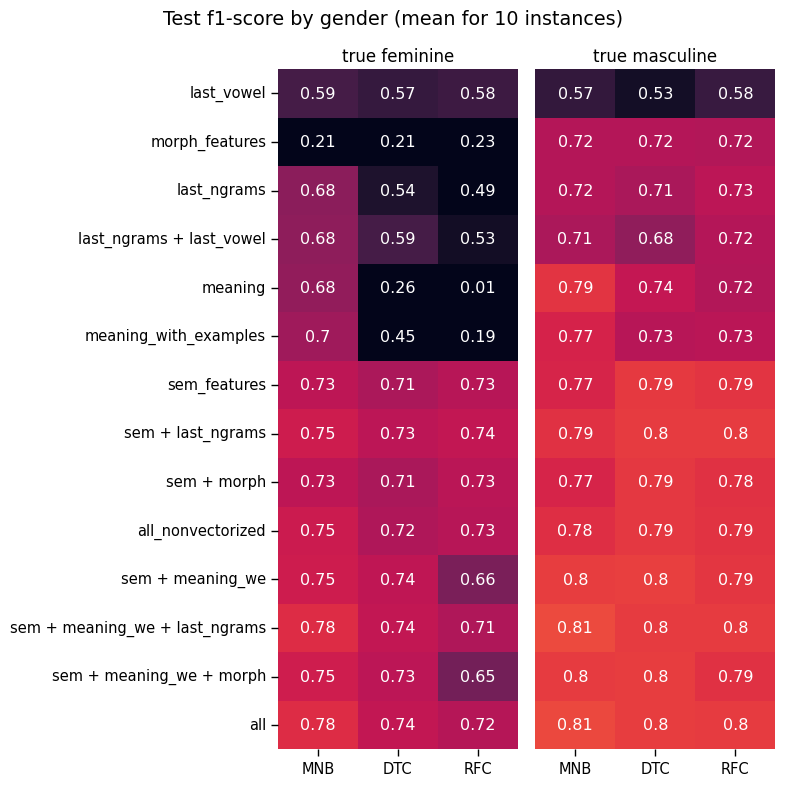

In [28]:
class_scores = {}
for class_ in ("m", "f"):
    class_scores[class_] = {}
    for feature_ in mean_results:
        class_scores[class_][feature_] = {}
        for model_ in mean_results[feature_]:
            class_scores[class_][feature_][model_] = mean_results[feature_][model_][f"{class_}_f1-score"]["mean"]

class_scores["f"], class_scores["m"] = pd.DataFrame(class_scores["f"]).transpose(), pd.DataFrame(class_scores["m"]).transpose()

fig, axes = plt.subplots(ncols=2, figsize=(8, 8))
ax1, ax2 = axes

sns.heatmap(class_scores["f"], vmin=0.5, vmax=1, annot=True, cbar=False, ax=ax1)
sns.heatmap(class_scores["m"], vmin=0.5, vmax=1, annot=True, cbar=False, yticklabels=False, ax=ax2)
ax1.set_title("true feminine")
ax2.set_title("true masculine")
#for ax in [ax1, ax2]:
#    plt.sca(ax)
#    plt.xticks(rotation=20, ha="right")
fig.suptitle(f"Test f1-score by gender (mean for {N_RS} instances)")
fig.tight_layout()
plt.savefig(f"f1_gender_test{selected}.png", bbox_inches='tight', dpi=DPI)
plt.show()

In [ ]:
class_scores = {}
for class_ in ("m", "f"):
    class_scores[class_] = {}
    for feature_ in mean_results:
        class_scores[class_][feature_] = {}
        for model_ in mean_results[feature_]:
            class_scores[class_][feature_][model_] = mean_results[feature_][model_][f"{class_}_f1-score"]["std"]

class_scores["f"], class_scores["m"] = pd.DataFrame(class_scores["f"]).transpose(), pd.DataFrame(class_scores["m"]).transpose()

fig, axes = plt.subplots(ncols=2, figsize=(8, 8))
ax1, ax2 = axes

sns.heatmap(class_scores["f"], vmin=0, vmax=0.5, annot=True, cbar=False, ax=ax1)
sns.heatmap(class_scores["m"], vmin=0, vmax=0.5, annot=True, cbar=False, yticklabels=False, ax=ax2)
ax1.set_title("true feminine")
ax2.set_title("true masculine")
#for ax in [ax1, ax2]:
#    plt.sca(ax)
#    plt.xticks(rotation=20, ha="right")
fig.suptitle(f"Standard deviation of test f1-score by gender (for {N_RS} instances)")
fig.tight_layout()
plt.savefig(f"f1_gender_test_std{selected}.png", bbox_inches='tight', dpi=DPI)
plt.show()

### Accuracy

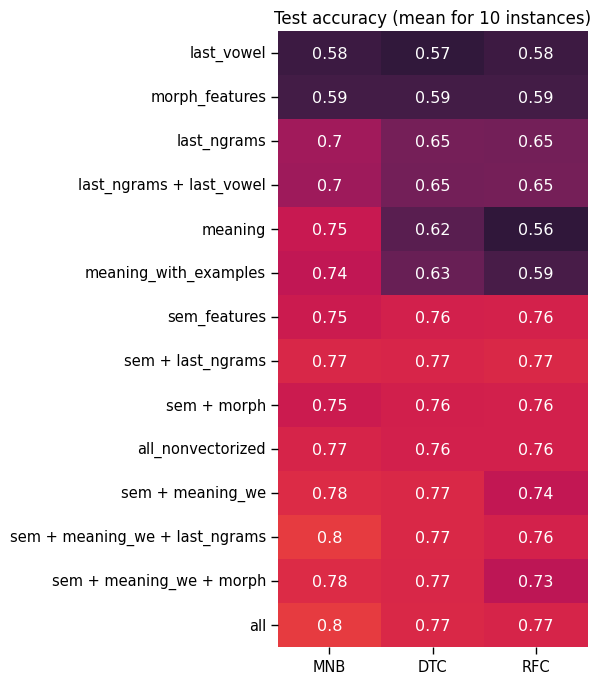

In [29]:
scores = {}
for feature_ in mean_results:
    scores[feature_] = [mean_results[feature_][model_]["accuracy"]["mean"] for model_ in mean_results[feature_]]
scores = pd.DataFrame(scores, index=mean_results[feature_]).transpose()

plt.figure(figsize=(4, 8))
sns.heatmap(scores, vmin=0.5, vmax=1, annot=True, cbar=False)
plt.title(f"Test accuracy (mean for {N_RS} instances)")
#plt.xticks(rotation=20, ha="right")
plt.savefig(f"accuracy_test{selected}.png", bbox_inches='tight', dpi=DPI)
plt.show()

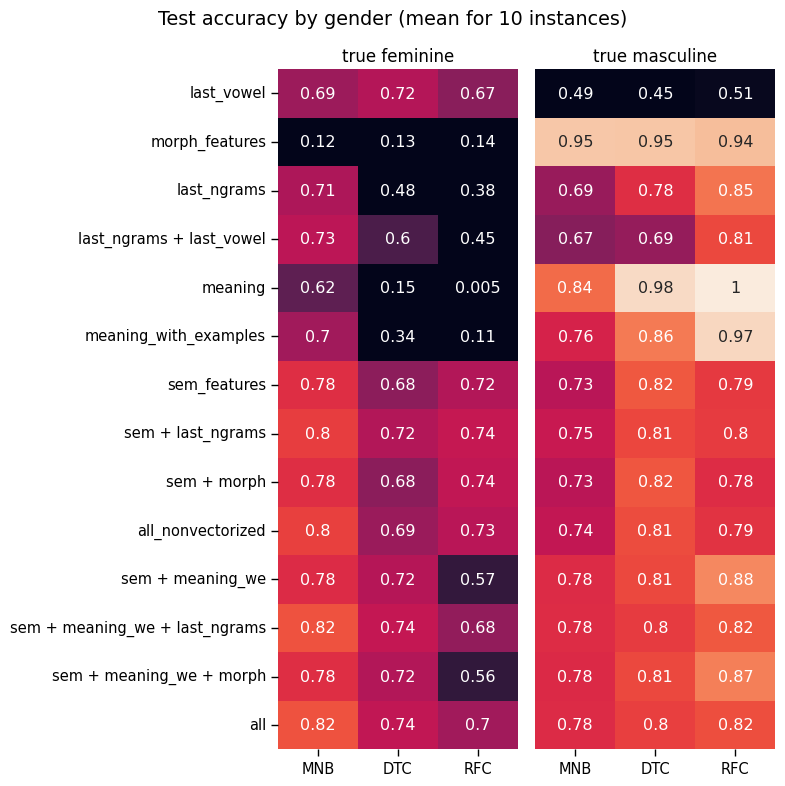

In [30]:
class_scores = {}
for class_ in ("m", "f"):
    class_scores[class_] = {}
    for feature_ in mean_results:
        class_scores[class_][feature_] = {}
        for model_ in mean_results[feature_]:
            class_scores[class_][feature_][model_] = mean_results[feature_][model_][f"{class_}_accuracy"]["mean"]

class_scores["f"], class_scores["m"] = pd.DataFrame(class_scores["f"]).transpose(), pd.DataFrame(class_scores["m"]).transpose()

fig, axes = plt.subplots(ncols=2, figsize=(8, 8))
ax1, ax2 = axes

sns.heatmap(class_scores["f"], vmin=0.5, vmax=1, annot=True, cbar=False, ax=ax1)
sns.heatmap(class_scores["m"], vmin=0.5, vmax=1, annot=True, cbar=False, yticklabels=False, ax=ax2)
ax1.set_title("true feminine")
ax2.set_title("true masculine")
#for ax in [ax1, ax2]:
#    plt.sca(ax)
#    plt.xticks(rotation=20, ha="right")
fig.suptitle(f"Test accuracy by gender (mean for {N_RS} instances)")
fig.tight_layout()
plt.savefig(f"accuracy_gender_test{selected}.png", bbox_inches='tight', dpi=DPI)
plt.show()

### Feature importances

In [31]:
RFC_importances = [show_importances(
    models["all_nonvectorized"]["RFC"][rseed], all_nonvectorized_feature_names).sort_values("feature").set_index("feature") for rseed in RANDOM_SEEDS]
RFC_importances = pd.concat(RFC_importances, axis=1)[:20]
RFC_importances.columns = [f"col{i}" for i in range(len(RFC_importances.columns))]
RFC_importances = RFC_importances.mean(axis=1).sort_values(ascending=False)

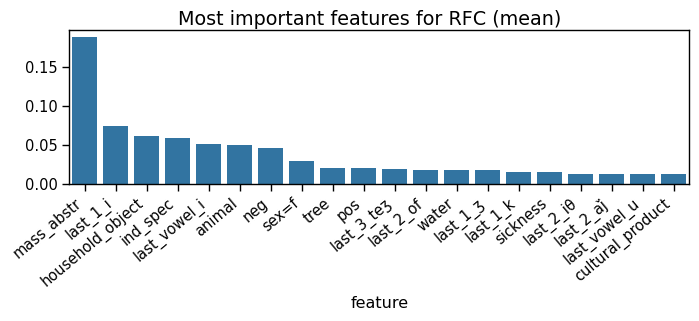

In [32]:
plt.figure(figsize=(8, 2))
sns.barplot(RFC_importances)
ax = axes
plt.xticks(rotation=40, ha="right")
plt.suptitle(f"Most important features for RFC (mean)")
plt.savefig(f"importances_rfc.png", bbox_inches='tight', dpi=DPI)
plt.show()

### DTC Tree

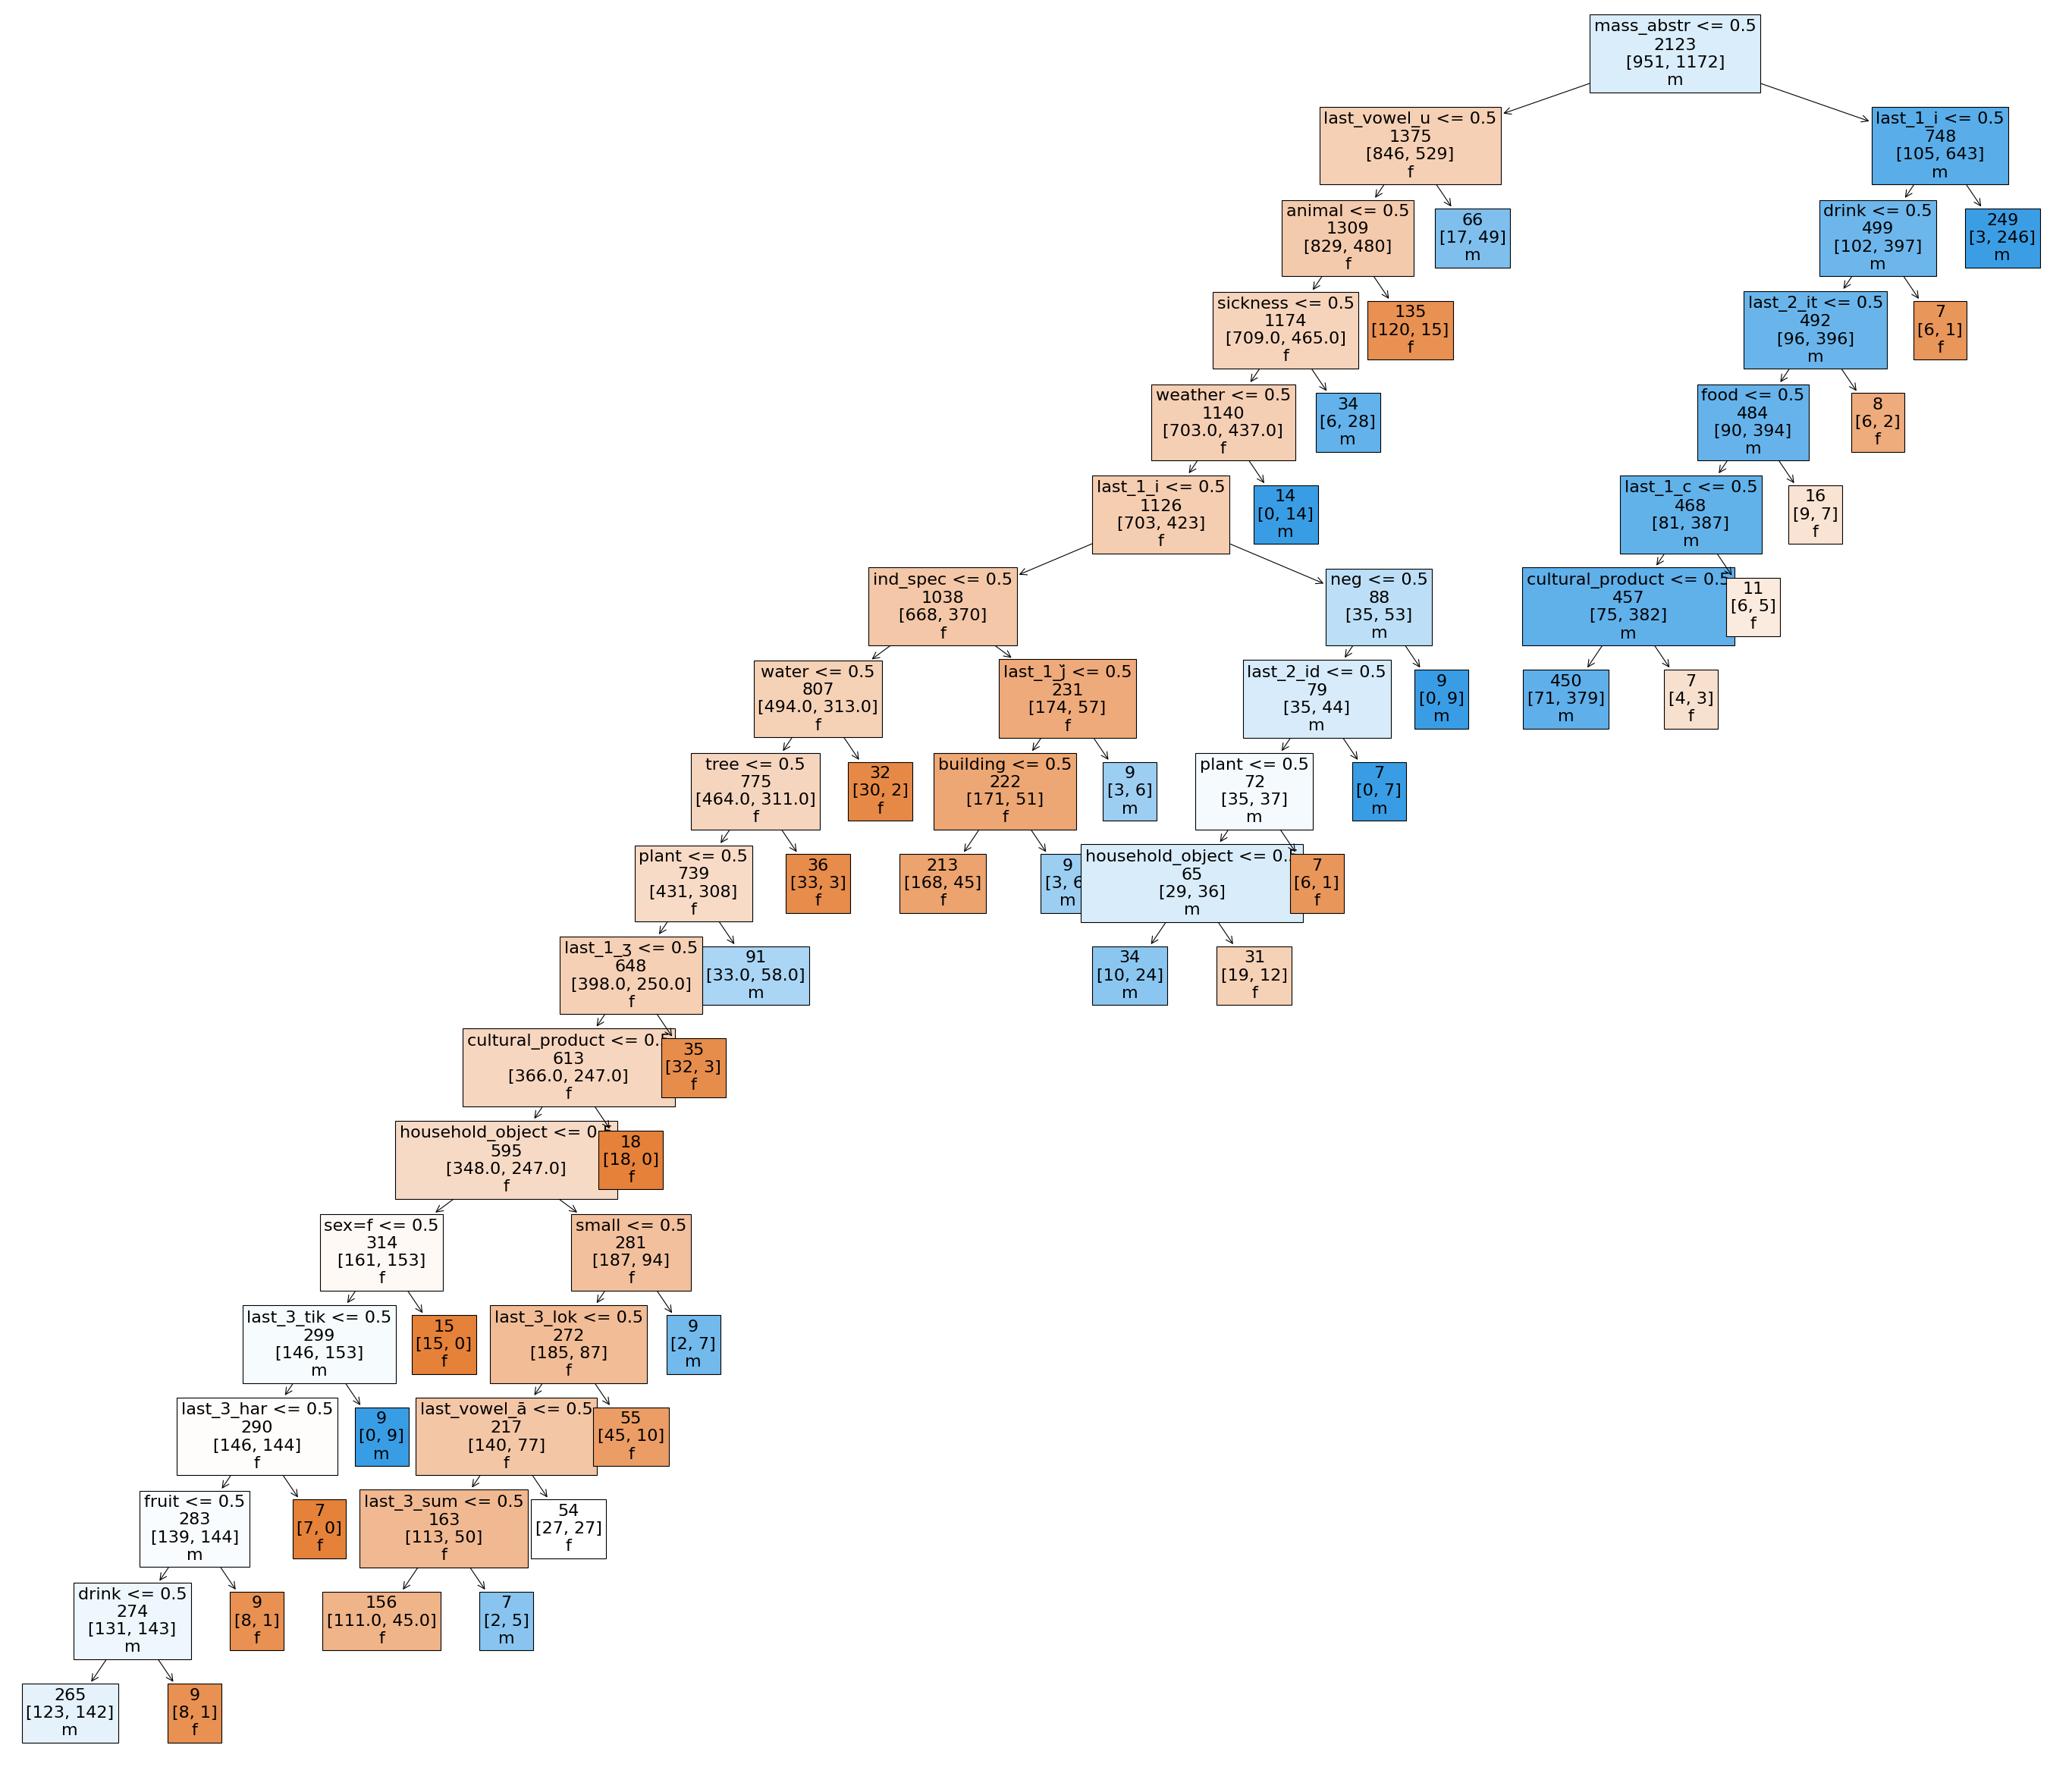

In [33]:
plt.figure(figsize=(35, 30))
plot_tree(models["all_nonvectorized"]["DTC"][RANDOM_SEEDS[1]], filled=True,
          feature_names=all_nonvectorized_feature_names,
          #max_depth=10,
          class_names=("f", "m"),
          impurity=False, label="none", fontsize=16)
plt.savefig("DTC_tree.png", dpi=DPI//4)
plt.show()

### Predictions

In [34]:
predictions = {}
for FEATURE in y_pred:
    for MODEL in y_pred[FEATURE]:
        predictions[f"{MODEL.upper()}_{FEATURE}"] = list(y_pred[FEATURE][MODEL][RANDOM_SEEDS[0]])

predictions = pd.DataFrame(predictions, index=y_test[RANDOM_SEEDS[0]].index)
predictions = pd.merge(data, predictions, left_index=True, right_index=True)

for FEATURE in y_pred:
    for MODEL in y_pred[FEATURE]:
        predictions[f"{MODEL.upper()}_{FEATURE}"] = np.where(
            predictions[f"{MODEL.upper()}_{FEATURE}"] == predictions["meaning_gender"], "true", "false")

predictions.to_csv("res_predictions.csv")

In [35]:
predictions_f = predictions[predictions["meaning_gender"] == "f"]
predictions_m = predictions[predictions["meaning_gender"] == "m"]

def plot_prediction_correlation(FEATURE_1, FEATURE_2):
    fig, axes = plt.subplots(ncols=2, figsize=(5, 2.5))
    ax1, ax2 = axes
    
    sns.heatmap(pd.crosstab(predictions_f[FEATURE_1], predictions_f[FEATURE_2],
                            normalize="all"),
                vmin=0, vmax=1, annot=True, cbar=False, ax=ax1)
    sns.heatmap(pd.crosstab(predictions_m[FEATURE_1], predictions_m[FEATURE_2],
                            normalize="all"),
                vmin=0, vmax=1, annot=True, cbar=False, ax=ax2)
    ax1.set_title("true feminine")
    ax2.set_title("true masculine")
    fig.suptitle("Correlation between two predictors")
    fig.tight_layout()
    plt.savefig(f"predictors_{FEATURE_1}_{FEATURE_2}.png", bbox_inches="tight", dpi=DPI)
    plt.show()

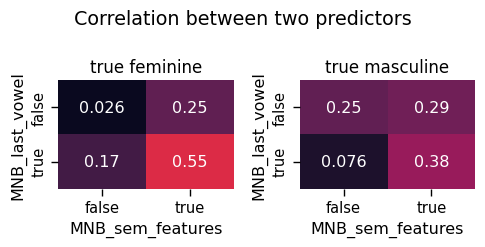

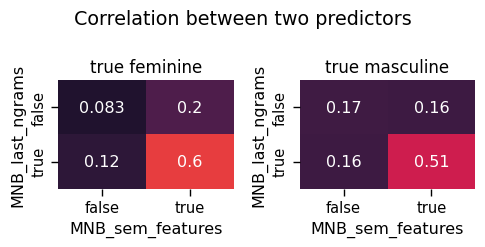

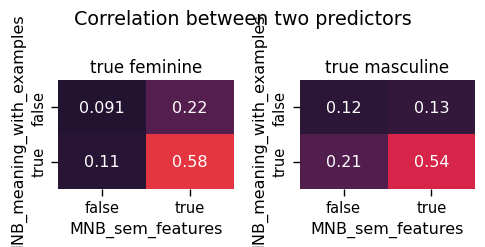

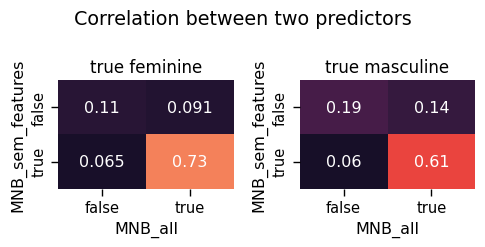

In [36]:
MODEL = "MNB"
FEATURE_2 = 'sem_features'

for FEATURE_1 in ('last_vowel', 'last_ngrams', 'meaning_with_examples'):
    plot_prediction_correlation(f"{MODEL}_{FEATURE_1}", f"{MODEL}_{FEATURE_2}")
plot_prediction_correlation(f"{MODEL}_sem_features", f"{MODEL}_all")